In [1]:
import sys
sys.path.append("../")
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = (20.0, 16.0) 

## black level estimation

In [2]:
rIm=read_raw("../static_videos/lowlight_frame47_rg10.raw", frame = 47)
print(rIm.shape, rIm.dtype)
bk_lvl = int(rIm[0].mean())
print("black level of the sensor: ", bk_lvl)

(47, 2174, 3864) int16
black level of the sensor:  50


## low light single frame demosaicking

In [3]:
rIm=read_raw("../static_videos/lowlight3_frame47_tremor_rg10_2.raw", frame = 8)
rIm = rIm[:, :2048, :3584]
rIm_single = rIm[0] - bk_lvl
rIm_single = np.clip(rIm_single, 0, 1023)
print_stat("rIm_single",rIm_single)
bit_length = np.log2(rIm_single.max())
print("bit_length", bit_length)

rIm_single stat: max: 33, min: 0, mean: 6.868077959333148, std: 3.412622179611001
bit_length 5.044394


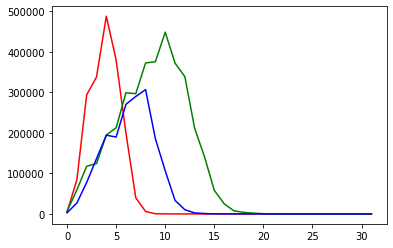

In [4]:
plot_histogram(rIm_single, bit_length)

In [5]:
rgbIm_single = demosaic(rIm_single)

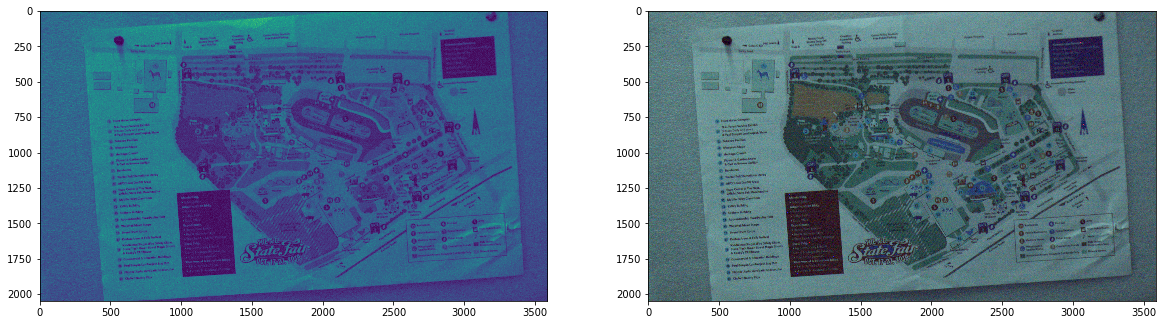

In [6]:
rgbIm_adj_single = adjustColor(rgbIm_single,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_single)
ax[1].imshow(rgbIm_adj_single)
plt.show()

## stack and demosaicking

In [7]:
rIm_sum = rIm.sum(axis = 0) - bk_lvl* rIm.shape[0]
print_stat("rIm_sum", rIm_sum)
bit_length = np.log2(rIm_sum.max())
print("bit_length", bit_length)

rIm_sum stat: max: 231, min: 2, mean: 55.034948757716585, std: 25.377276028644076
bit_length 7.851749041416057


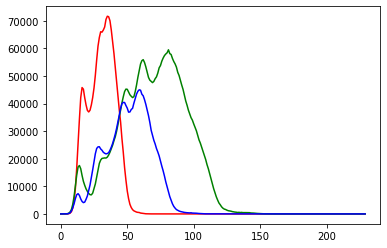

In [8]:
plot_histogram(rIm_sum, bit_length)

In [9]:
rIm_sum = np.clip(rIm_sum, 0, 1023)

In [10]:
rgbIm = demosaic(rIm_sum)

In [11]:
rgbIm_adj = adjustColor(rgbIm,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)

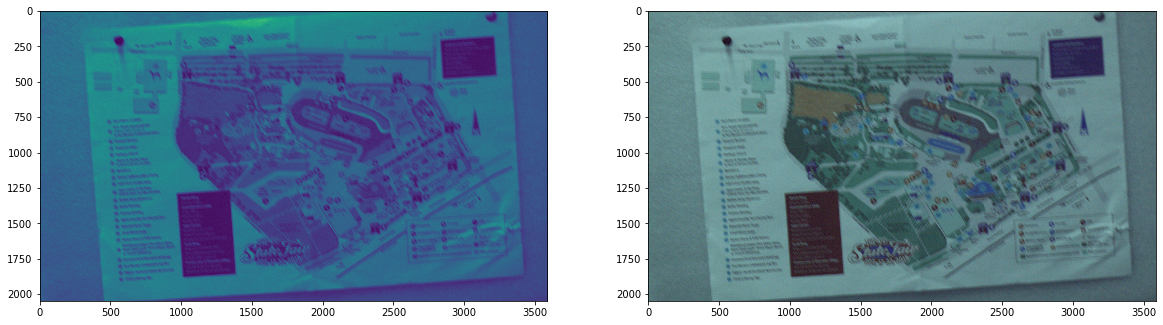

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rIm_sum)
ax[1].imshow(rgbIm_adj)
plt.show()

In [13]:
from merge_utils import *
from align_utils import *

In [14]:
final = rIm[0].copy().astype(np.float64)
for idx in range(1, 8):
    ref = rIm[0]
    alt = rIm[idx]
    final_align_field = np.load('final_align_field_{}.npy'.format(idx))
    upsampled_align_field = upsample_align_field(final_align_field)
    bi_align_field = bilateral_upsample(upsampled_align_field)
    merged_frame = merge(ref, alt, bi_align_field)
    final += merged_frame

In [21]:
rIm_merge = final[32:-32, 32:-32] - bk_lvl* rIm.shape[0]
rIm_merge = rIm_merge.astype(np.int16)
print_stat("rIm_merge", rIm_merge)
bit_length = np.log2(rIm_merge.max())
print("bit_length", bit_length)

rIm_merge stat: max: 232, min: 0, mean: 54.6875715954912, std: 27.033370106076163
bit_length 7.857981


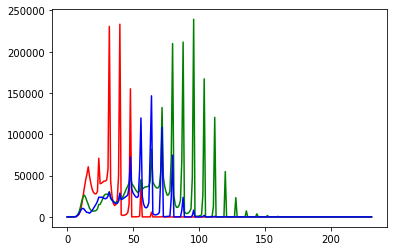

In [22]:
plot_histogram(rIm_merge, bit_length)

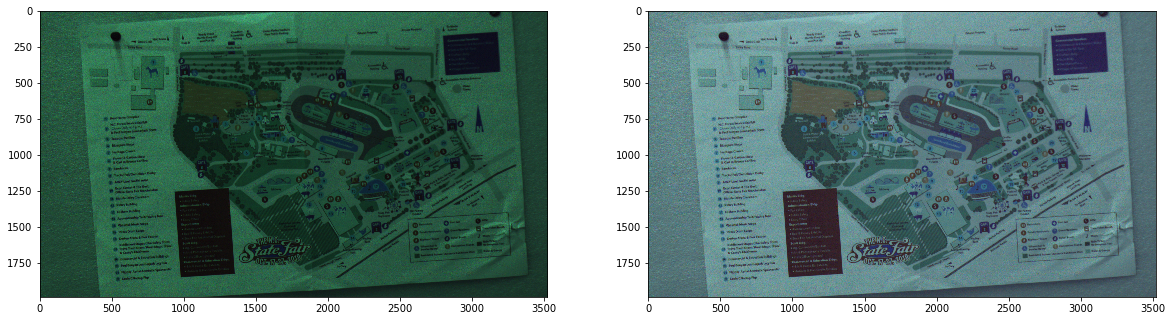

In [23]:
rgbIm_merge = demosaic(rIm_merge)
rgbIm_adj_merge = adjustColor(rgbIm_merge,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = 1.25, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 16))
ax[0].imshow(rgbIm_merge)
ax[1].imshow(rgbIm_adj_merge)
plt.show()

In [25]:
cv2.imwrite("rgbIm_adj_merge.png", rgbIm_adj_merge[..., ::-1])
cv2.imwrite("rgbIm_adj.png", rgbIm_adj[32:-32, 32:-32, ::-1])
cv2.imwrite("rgbIm_adj_single.png", rgbIm_adj_single[32:-32, 32:-32, ::-1])

True

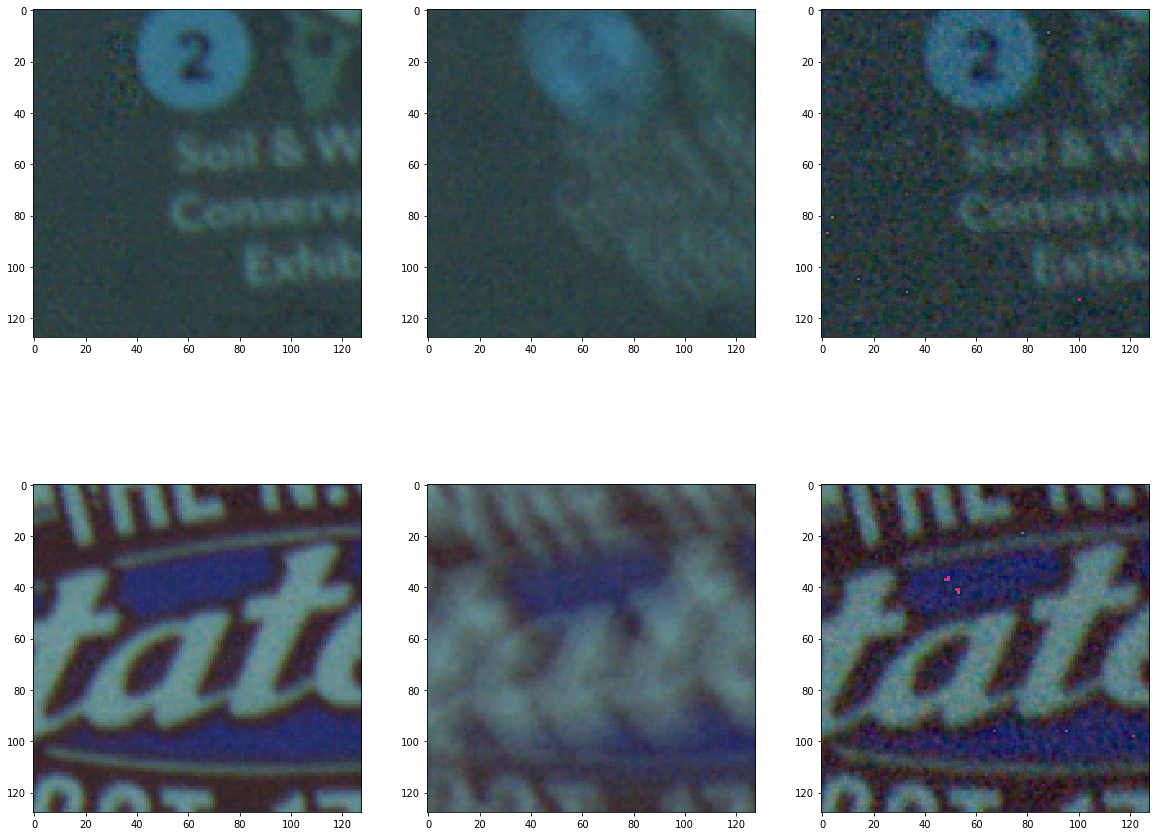

In [33]:
rgbIm_adj = cv2.imread("rgbIm_adj.png")[..., ::-1]
rgbIm_adj_single = cv2.imread("rgbIm_adj_single.png")[..., ::-1]
rgbIm_adj_merge = cv2.imread("rgbIm_adj_merge.png")[..., ::-1]

fig, ax = plt.subplots(2, 3, figsize=(20, 16))
ax[0][0].imshow(rgbIm_adj_merge[800:928, 1020:1148])
ax[0][1].imshow(rgbIm_adj[800:928, 1020:1148])
ax[0][2].imshow(rgbIm_adj_single[800:928, 1020:1148])
ax[1][0].imshow(rgbIm_adj_merge[1600:1728, 1500:1628])
ax[1][1].imshow(rgbIm_adj[1600:1728, 1500:1628])
ax[1][2].imshow(rgbIm_adj_single[1600:1728, 1500:1628])
plt.show()